# Minimum Wage Simulation -- Estimator Comparisons



In [1]:
import os
# set wd to Users/boyuchen/Documents/UBC/RA/minimum_wage
os.chdir('/Users/boyuchen/Documents/UBC/RA/minimum_wage')

from codes.simulation_functions import *

In [2]:
log_wages = generate_log_wages(100_000)  

# run df_grouped for four proability scenarios:
# real_m_pre, real_m_post, P_o, P_b, P_s
scenarios = {
    'S1': (10, 12, 0.3, 0.5, 0),
    'S2': (10, 12, 0.3, 0, 0.5),
    'S3': (13, 15, 0.3, 0.5, 0),
    'S4': (13, 15, 0.3, 0, 0.5),
}

## Cengiz et al.(2019) Method

In [3]:
# Function to apply Cengiz method for employment changes and wage effects
def cengiz_method(log_wages, scenario):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenario
    m_pre = np.log(real_m_pre)
    m_post = np.log(real_m_post)

    df_pre = impose_minimum_wage(log_wages, m_pre, P_o, P_b, P_s)
    df_post = impose_minimum_wage(log_wages, m_post, P_o, P_b, P_s)

    def to_real_scale(log_wages):
        return np.exp(log_wages)

    df_pre['real_wages'] = to_real_scale(df_pre['adjusted_log_wages'])
    df_post['real_wages'] = to_real_scale(df_post['adjusted_log_wages'])

    # Define the 75 percentile of the pre-wage distribution (Wbar)
    Wbar = df_pre['real_wages'].quantile(0.75)

    bin_width = 0.25

    # Assign bins for pre and post data, excluding unemployed
    bins_pre = np.arange(0, Wbar + bin_width, bin_width)
    bins_post = np.arange(0, Wbar + bin_width, bin_width)

    df_pre['wage_bin'] = pd.cut(df_pre['real_wages'], bins=bins_pre, right=False)
    df_post['wage_bin'] = pd.cut(df_post['real_wages'], bins=bins_post, right=False)

    # Calculate the pre-period average wage of workers below the initial minimum wage
    affected_pre = df_pre[df_pre['original_log_wages'] < m_pre]
    # affected_post = df_post[df_post['original_log_wages'] < m_pre]

    average_affected_wage_pre = affected_pre['real_wages'].mean()
    affected_wage_bill_pre = affected_pre['real_wages'].sum()
    total_wage_bill_pre = df_pre['real_wages'].sum()
    total_wage_bill_post = df_post['real_wages'].sum()
    Δtotal_wage_bill = total_wage_bill_post - total_wage_bill_pre
    
    # Count the number of workers in each wage bin, excluding unemployed
    pre_counts = df_pre['wage_bin'].value_counts().sort_index()
    post_counts = df_post['wage_bin'].value_counts().sort_index()

    # count the total number of affected worker in the pre-period using affected_pre
    total_affected_pre = affected_pre.shape[0]

    pre_counts = pre_counts.reindex_like(post_counts).fillna(0)
    post_counts = post_counts.reindex_like(pre_counts).fillna(0)

    # Create a boolean mask for intervals where the left edge is greater than or equal to m_post
    mask_post = np.array([interval.left >= np.exp(m_post).round(3) for interval in post_counts.index])
    mask_pre = np.array([interval.left >= np.exp(m_post).round(3) for interval in pre_counts.index])

    # Calculate excess and missing jobs, only considering bins below Wbar
    Δa = post_counts[mask_post].sum() - pre_counts[mask_pre].sum()
    Δb = post_counts[~mask_post].sum() - pre_counts[~mask_pre].sum()
    Δemp = Δa + Δb

    total_employed_pre = pre_counts.sum()

    Δm = np.exp(m_post) - np.exp(m_pre)
    employment_elasticity = (Δemp / total_employed_pre) / (Δm / np.exp(m_pre))

    # change in total employment over the "affected workers" in the pre-period
    affected_employment_change = Δemp / total_affected_pre

    # change in wage bills of affected workers is the pre-period affected wage bill + the total change in wage bill of all workers
    affected_new_wage_bill = affected_wage_bill_pre + Δtotal_wage_bill
    affected_employment_post = total_affected_pre + Δemp

    # calculate percentage change in the average wage of affected workers
    new_average_wage_affected = affected_new_wage_bill / affected_employment_post

    # calculate percentage change in the average wage of affected workers
    percentage_change_average_wage_affected = (new_average_wage_affected - average_affected_wage_pre) / average_affected_wage_pre

    # calculate own_elasticity 
    own_wage_elasticity = affected_employment_change / percentage_change_average_wage_affected

    return {
        'employment_elasticity': employment_elasticity,
        'own_wage_elasticity': own_wage_elasticity,
        'percentage_change_affected_employment': affected_employment_change,
        'percentage_change_average_wage_affected': percentage_change_average_wage_affected,
        'Δa': Δa,
        'Δb': Δb,
        'bins_pre': pre_counts.index.tolist(),
        'pre_counts': pre_counts,
        'post_counts': post_counts
    }



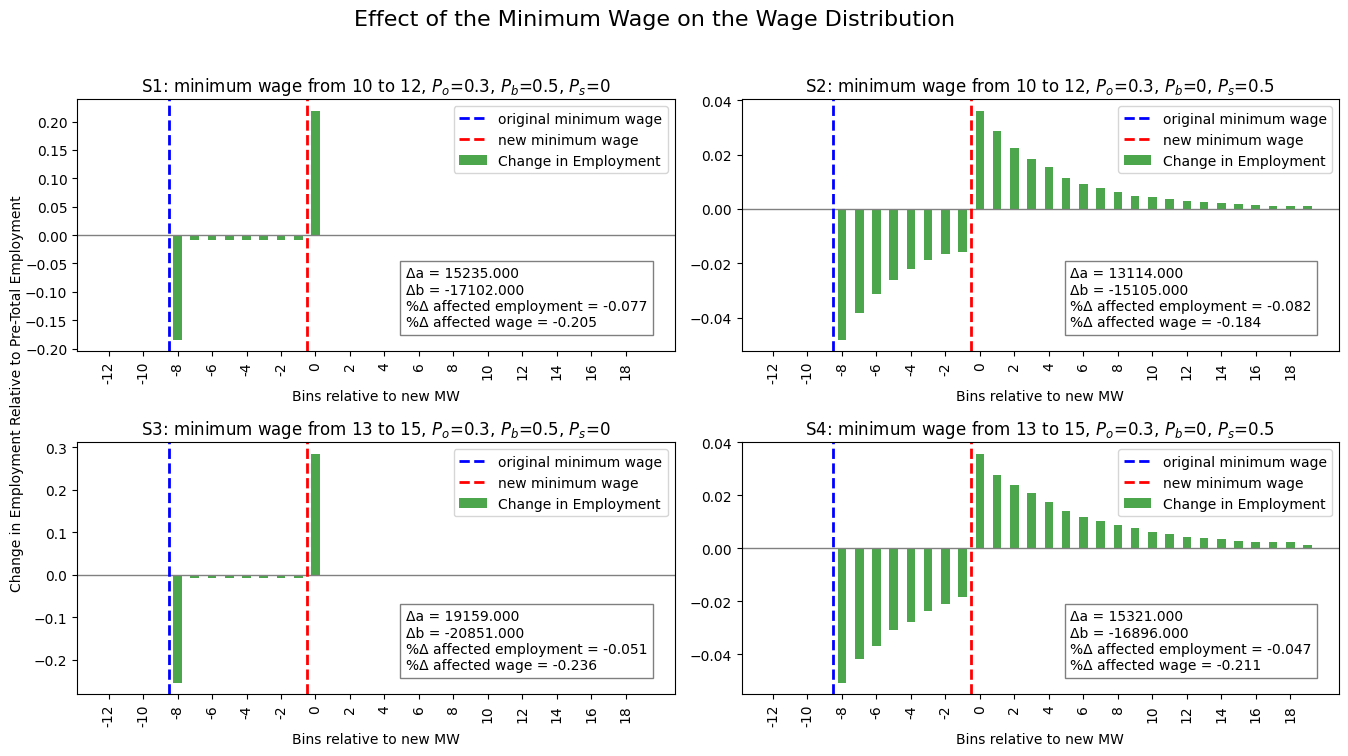

In [4]:
def plot_changes_in_employment(result, scenario_name, scenario):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenario
    pre_counts = result['pre_counts']
    post_counts = result['post_counts']
    bins_pre = result['bins_pre']
    Δa = result['Δa']
    Δb = result['Δb']
    percentage_change_affected_employment = result['percentage_change_affected_employment']
    percentage_change_average_wage_affected = result['percentage_change_average_wage_affected']

    # Calculate the changes in employment
    employment_changes = post_counts - pre_counts

    # Calculate the total pre-employment
    total_pre_employment = pre_counts.sum()

    # Calculate relative changes to pre-total employment
    relative_employment_changes = employment_changes / total_pre_employment

    # Extract intervals for display
    intervals = [interval.left for interval in bins_pre]

    # Calculate bins relative to real_m_post
    bins_relative_to_post = [round((interval - real_m_post) / (bins_pre[1].left - bins_pre[0].left)) for interval in intervals]

    # Find the positions for m_pre and m_post
    m_pre_pos = next(i for i, interval in enumerate(intervals) if interval >= real_m_pre)
    m_post_pos = next(i for i, interval in enumerate(intervals) if interval >= real_m_post)

    # Select 10 bins below real_m_pre and 30 bins above real_m_post
    start_idx = max(0, m_pre_pos - 4)
    end_idx = min(len(intervals), m_post_pos + 20)

    bins_relative_to_post = bins_relative_to_post[start_idx:end_idx]
    relative_employment_changes = relative_employment_changes[start_idx:end_idx]

    bar_width = 0.5
    index = np.arange(len(bins_relative_to_post))

    ax.bar(index, relative_employment_changes, bar_width, alpha=0.7, color='green', label='Change in Employment')

    ax.set_xlabel('Bins relative to new MW')
    # ax.set_ylabel('% Change in Employment Relative to Pre-Total Employment')
    ax.set_title(f'{scenario_name}: minimum wage from {real_m_pre} to {real_m_post}, $P_o$={P_o}, $P_b$={P_b}, $P_s$={P_s}')
    ax.set_xticks(index[::2])
    ax.set_xticklabels(bins_relative_to_post[::2], rotation=90)

    # Add grey line at y=0
    ax.axhline(y=0, color='grey', linestyle='-', linewidth=1)

    # Adjust positions for m_pre and m_post lines to match the selected bins
    m_pre_pos_adj = m_pre_pos - start_idx
    m_post_pos_adj = m_post_pos - start_idx

    # Add m_pre and m_post lines
    ax.axvline(m_pre_pos_adj - 0.5, color='blue', linestyle='--', linewidth=2, label='original minimum wage')
    ax.axvline(m_post_pos_adj - 0.5, color='red', linestyle='--', linewidth=2, label='new minimum wage')

    # Add parameters to the lower left
    ax.text(0.55, 0.1,
             f'Δa = {Δa:.3f}\nΔb = {Δb:.3f}\n%Δ affected employment = {percentage_change_affected_employment:.3f}\n%Δ affected wage = {percentage_change_average_wage_affected:.3f}',
             bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)

    ax.legend()
    plt.tight_layout()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# Generate and plot results for each scenario
for ax, (scenario_name, scenario) in zip(axs.flatten(), scenarios.items()):
    result = cengiz_method(log_wages, scenario)
    plot_changes_in_employment(result, scenario_name, scenario)

# Set common ylabel
fig.text(0.04, 0.5, 'Change in Employment Relative to Pre-Total Employment', va='center', rotation='vertical')
plt.suptitle('Effect of the Minimum Wage on the Wage Distribution', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()


## Naive percentile OLS


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

def calculate_percentiles(log_wages, scenario):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenario
    m_pre = np.log(real_m_pre)
    m_post = np.log(real_m_post)
    df_pre = impose_minimum_wage(log_wages, m_pre, P_o, P_b, P_s)
    df_post = impose_minimum_wage(log_wages, m_post, P_o, P_b, P_s)


    def to_real_scale(log_wages):
        return np.exp(log_wages)

    df_pre['real_wages'] = to_real_scale(df_pre['adjusted_log_wages'])
    df_post['real_wages'] = to_real_scale(df_post['adjusted_log_wages'])

    percentiles = np.arange(0, 85, 5)

    pre_percentiles = np.percentile(df_pre['real_wages'].dropna(), percentiles)
    post_percentiles = np.percentile(df_post['real_wages'].dropna(), percentiles)
    
    # Calculate 95th percentile
    p95_pre = np.percentile(df_pre['real_wages'].dropna(), 95)
    p95_post = np.percentile(df_post['real_wages'].dropna(), 95)
    x_limit = max(p95_pre, p95_post)

    return pre_percentiles, post_percentiles, df_pre['real_wages'].dropna(), df_post['real_wages'].dropna(), x_limit


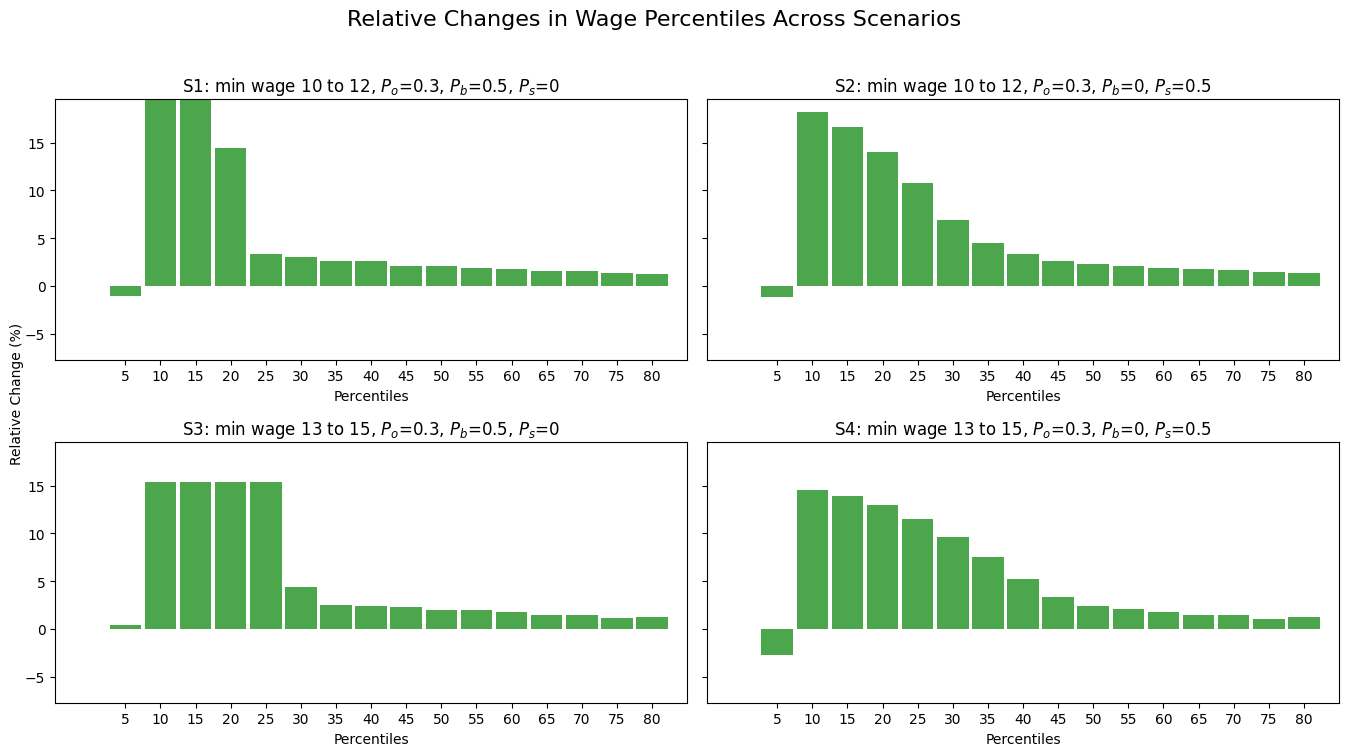

In [17]:
# Define the figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Generate and plot results for each scenario
for i, (scenario_name, params) in enumerate(scenarios.items()):
    pre_percentiles, post_percentiles, _, _, x_limit = calculate_percentiles(log_wages, params)
    relative_changes = (post_percentiles - pre_percentiles) / pre_percentiles * 100

    ax = axes[i]
    percentiles = np.arange(5, 85, 5)


    ax.bar(percentiles, relative_changes[1:], width=4.5, alpha=0.7, color='green')
    ax.set_xlabel('Percentiles')
    # ax.set_ylabel('Relative Change (%)')
    ax.set_title(f'{scenario_name}: min wage {params[0]} to {params[1]}, $P_o$={params[2]}, $P_b$={params[3]}, $P_s$={params[4]}')
    ax.set_xticks(percentiles)
    ax.set_xlim([-5, 85])
    ax.set_ylim([min(relative_changes[1:]) - 5, max(relative_changes[1:]) + 5])

# Set the main title
plt.suptitle('Relative Changes in Wage Percentiles Across Scenarios', fontsize=16)
fig.text(0.04, 0.5, 'Relative Change (%)', va='center', rotation='vertical')

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()


## Hazard Estimator


In [7]:
def prepare_hazard_var(log_wages, real_m_pre, real_m_post, P_o=0.2, P_b=0, P_s=0.5):
    m_pre = np.log(real_m_pre)
    m_post = np.log(real_m_post)

    # Assuming impose_minimum_wage function is defined elsewhere
    df_pre = impose_minimum_wage(log_wages, m_pre, P_o, P_b, P_s)
    df_post = impose_minimum_wage(log_wages, m_post, P_o, P_b, P_s)

    def to_real_scale(log_wages):
        return np.exp(log_wages)

    df_pre['real_wages'] = to_real_scale(df_pre['adjusted_log_wages'])
    df_post['real_wages'] = to_real_scale(df_post['adjusted_log_wages'])

    # Simplify bins
    bins = [0, 4] + list(np.arange(4, 20, 0.1)) + [20, np.inf]

    def create_min_dummies(df, real_m):
        # Create bins and labels
        df['wagcat'] = pd.cut(df['real_wages'], bins=bins, labels=False, duplicates='drop')
        # Change wagcat to be integer or NaN
        df['wagcat'] = df['wagcat'].astype('Int64')

        # Find the bin number containing the minimum wage
        m_bin = pd.cut([real_m], bins=bins, labels=False, duplicates='drop')[0]

        # Aggregate data by bin
        df_grouped = df.groupby('wagcat').size().reset_index(name='fweight')
        max_bin = df_grouped['wagcat'].max()
        all_bins = pd.DataFrame({'wagcat': range(max_bin + 1)})
        df_grouped = pd.merge(all_bins, df_grouped, on='wagcat', how='left').fillna(0)

        # Create min and min* variables
        df_grouped['min'] = np.where(df_grouped['wagcat'] == m_bin, 1, 0)
        df_grouped['min1115b'] = np.where((df_grouped['wagcat'] >= m_bin - 15) & (df_grouped['wagcat'] <= m_bin - 11), 1, 0)
        df_grouped['min610b'] = np.where((df_grouped['wagcat'] >= m_bin - 10) & (df_grouped['wagcat'] <= m_bin - 6), 1, 0)
        df_grouped['min35b'] = np.where((df_grouped['wagcat'] >= m_bin - 5) & (df_grouped['wagcat'] <= m_bin - 3), 1, 0)
        df_grouped['min12b'] = np.where((df_grouped['wagcat'] >= m_bin - 2) & (df_grouped['wagcat'] <= m_bin - 1), 1, 0)
        df_grouped['min12a'] = np.where((df_grouped['wagcat'] >= m_bin + 1) & (df_grouped['wagcat'] <= m_bin + 2), 1, 0)
        df_grouped['min35a'] = np.where((df_grouped['wagcat'] >= m_bin + 3) & (df_grouped['wagcat'] <= m_bin + 5), 1, 0)
        df_grouped['min610a'] = np.where((df_grouped['wagcat'] >= m_bin + 6) & (df_grouped['wagcat'] <= m_bin + 10), 1, 0)
        df_grouped['min1115a'] = np.where((df_grouped['wagcat'] >= m_bin + 11) & (df_grouped['wagcat'] <= m_bin + 15), 1, 0)
        df_grouped['min1620a'] = np.where((df_grouped['wagcat'] >= m_bin + 16) & (df_grouped['wagcat'] <= m_bin + 20), 1, 0)

        # Create bin* dummies
        bin_dummies = pd.get_dummies(df_grouped['wagcat'], prefix='bin')
        df_grouped = pd.concat([df_grouped, bin_dummies], axis=1)
        # Ensure no missing bins
        
        return df_grouped

    # Create min dummies and group by bin-period for both pre and post data
    df_grouped_pre = create_min_dummies(df_pre, real_m_pre)
    df_grouped_pre['period'] = 'pre'

    df_grouped_post = create_min_dummies(df_post, real_m_post)
    df_grouped_post['period'] = 'post'

    # Combine pre and post data
    df_grouped = pd.concat([df_grouped_pre, df_grouped_post])

    # Calculate remain: cumulative sum of fweight in descending order of bins
    df_grouped = df_grouped.sort_values(by=['period', 'wagcat'], ascending=[True, False])
    df_grouped['remain'] = df_grouped.groupby('period')['fweight'].cumsum()

    # Sanity check 1: sum of min* variables must be 0 or 1
    min_vars = ['min','min610b', 'min35b', 'min12b', 'min12a', 'min35a', 'min610a', 'min1115a', 'min1620a']
    df_grouped['min_sum'] = df_grouped[min_vars].sum(axis=1)
    assert df_grouped['min_sum'].isin([0, 1]).all(), "Sanity check failed: sum of min* variables is not 0 or 1 for some rows."

    # Sanity check 2: sum of bin* variables must be 1
    bin_vars = [col for col in df_grouped.columns if col.startswith('bin')]
    df_grouped['bin_sum'] = df_grouped[bin_vars].sum(axis=1)
    assert (df_grouped['bin_sum'] == 1).all(), "Sanity check failed: sum of bin* variables is not 1 for some rows."

    # drop bin_sum and min_sum columns
    df_grouped = df_grouped.drop(columns=['bin_sum', 'min_sum'])
    
    return df_grouped


In [8]:
# loop through the scenarios
for scenario, params in scenarios.items():
    real_m_pre, real_m_post, P_o, P_b, P_s = params
    df_grouped = prepare_hazard_var(log_wages, real_m_pre, real_m_post, P_o, P_b, P_s)
    print(f"Scenario: {scenario}")
    df_grouped.to_stata(f'data/df_grouped_{scenario}.dta')

Scenario: S1
Scenario: S2
Scenario: S3
Scenario: S4


In [9]:
# %pip install stata_setup
import stata_setup
stata_setup.config("/Applications/Stata/", "se")


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      18.0
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2023 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user network, expiring 19 Aug 2024
Serial number: 401809301518
  Licensed to: 陳柏宇
               UBC

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000 but can be increased;
          see help set_maxvar.


In [10]:
%%stata
# execute the following do.file
do "codes/hazard simulation.do"


. # execute the following do.file
Unknown #command
. do "codes/hazard simulation.do"

. cd "/Users/boyuchen/Documents/UBC/RA/minimum_wage"
/Users/boyuchen/Documents/UBC/RA/minimum_wage

. 
. * Clear the existing Excel file or create a new one
. putexcel set tables/coefficients.xlsx, replace
note: file will be replaced when the first putexcel command is issued.

. 
. foreach s in S1 S2 S3 S4{
  2.     use data/df_grouped_`s'.dta, clear
  3. 
.     glm fweight min min610b min12a min12b min35a min35b min610a min1115a min1
> 620a bin* if remain>0 & wagcat~=161, link(cloglog) family(binomial remain) 
  4. 
.     * Extract the coefficients
.     matrix b = e(b)
  5.         
.         * Extract the variance-covariance matrix
.     matrix V = e(V)
  6. 
.     * Calculate standard errors (sqrt of diagonal elements of V)
.     matrix D = vecdiag(V) // Get the diagonal elements
  7.     matrix se = J(1, colsof(D), .)
  8.     forvalues i = 1/`=colsof(D)' {
  9.         matrix se[1,`i'] = sqrt(D

In [11]:
# Load the Excel file
file_path = 'tables/coefficients.xlsx'
df_s1 = pd.read_excel(file_path, sheet_name='S1', header=None)
df_s2 = pd.read_excel(file_path, sheet_name='S2', header=None)
df_s3 = pd.read_excel(file_path, sheet_name='S3', header=None)
df_s4 = pd.read_excel(file_path, sheet_name='S4', header=None)

# Function to format the data
def format_data(df):
    variables = df.iloc[1, 1:].values
    coefficients = df.iloc[2, 1:].values
    se = df.iloc[3, 1:].values
    data = pd.DataFrame({
        'Variable': variables,
        'Coefficient': coefficients,
        'SE': se
    })

    # only keep columns where variable start with "min"
    data = data[data['Variable'].str.startswith('min')]

    return data

# Format data for each sheet
data_s1 = format_data(df_s1)
data_s2 = format_data(df_s2)
data_s3 = format_data(df_s3)
data_s4 = format_data(df_s4)

# Combine all data into one DataFrame for plotting
data_s1['Scenario'] = 'S1'
data_s2['Scenario'] = 'S2'
data_s3['Scenario'] = 'S3'
data_s4['Scenario'] = 'S4'
all_data = pd.concat([data_s1, data_s2, data_s3, data_s4], ignore_index=True)

# Define the x-axis ranges for the variables
x_ranges = {
    'min': (0, .1),
    'min610b': (-1.0, -.5),
    'min35b': (-.5, -.2),
    'min12b': (-.2, .0),
    'min12a': (.1, .3),
    'min35a': (.3, .6),
    'min610a': (.6, 1.1),
    'min1115a': (1.1, 1.6),
    'min1620a': (1.6, 2.0)
}

# Filter the data for the variables of interest
filtered_data = all_data[all_data['Variable'].isin(x_ranges.keys())]


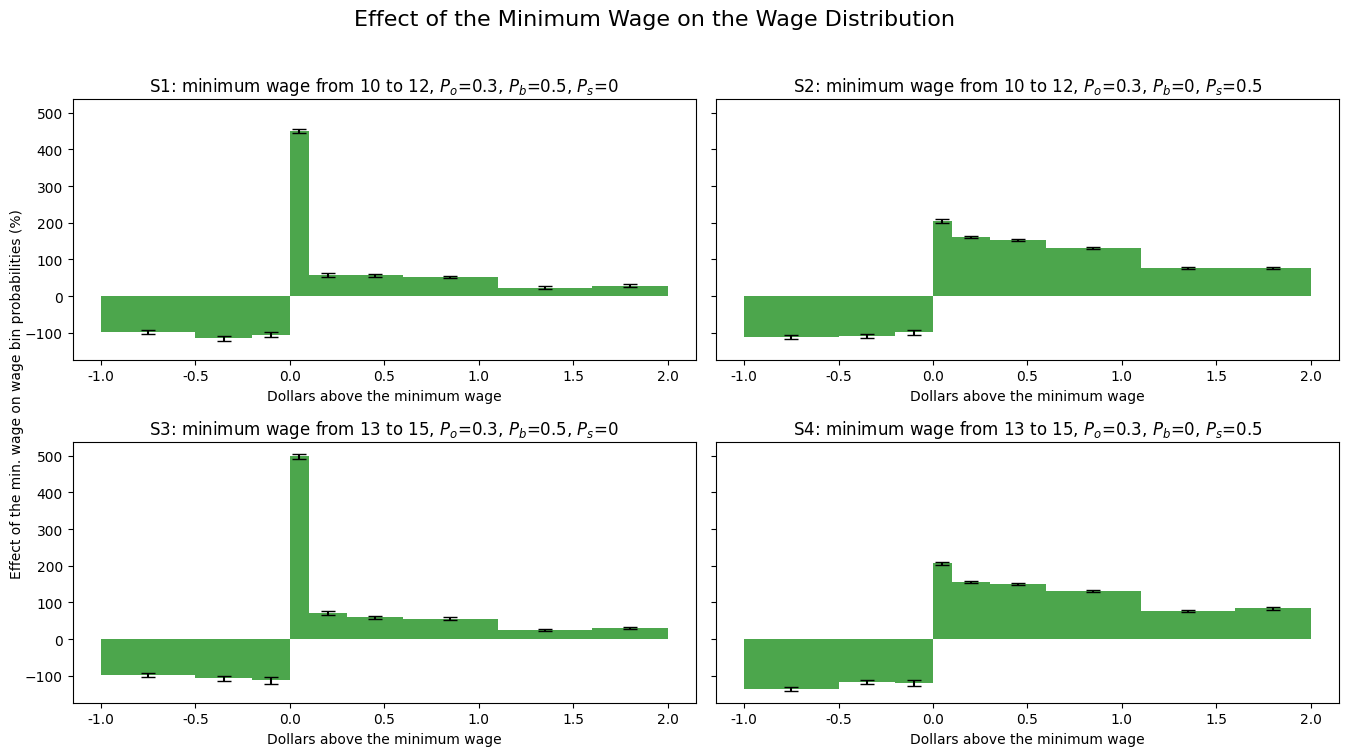

In [12]:
x_values = []
x_labels = []
widths = []
for var in filtered_data['Variable']:
    if var in x_ranges:
        range_start, range_end = x_ranges[var]
        x_values.append(np.mean([range_start, range_end]) * 10)  # Convert to dollar
        x_labels.append(f"{range_start} to {range_end}")
        widths.append((range_end - range_start) * 10)  # Convert to dollar

# Define the figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each scenario in a separate subplot
for i, scenario in enumerate(scenarios):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenarios[scenario]
    scenario_data = filtered_data[filtered_data['Scenario'] == scenario]
    x_scenario_values = [np.mean([x_ranges[var][0], x_ranges[var][1]]) for var in scenario_data['Variable']]  # Convert to percentage
    y_values = scenario_data['Coefficient'] * 100  # Convert to percentage
    y_err = scenario_data['SE'] * 100  # Convert to percentage
    scenario_widths = [(x_ranges[var][1] - x_ranges[var][0]) for var in scenario_data['Variable']]  # Convert to percentage
    
    # Plot the data
    axes[i].bar(x_scenario_values, y_values, width=scenario_widths, yerr=y_err, capsize=5, label=scenario, color = 'green', alpha = 0.7)
    axes[i].set_xlabel('Dollars above the minimum wage')
    axes[i].set_title(f'{scenario}: minimum wage from {real_m_pre} to {real_m_post}, $P_o$={P_o}, $P_b$={P_b}, $P_s$={P_s}')

    # Set x-ticks with a break of 5 bins (0.5 dollars)
    axes[i].set_xticks(np.arange(-1.0, 2.1, .5))
    axes[i].set_xticklabels(np.arange(-1.0, 2.1, 0.5))

# Set common ylabel
fig.text(0.04, 0.5, 'Effect of the min. wage on wage bin probabilities (%)', va='center', rotation='vertical')

# Set the main title
plt.suptitle('Effect of the Minimum Wage on the Wage Distribution', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()
